In [10]:
col_pal_sw_asynch = ['#C9B037','#6C5B7B']

In [ ]:
from joblib import Parallel, delayed
from bct import score_wu, rich_club_wu
from scipy.signal import welch
import fastdyn_fic_dmf as dmf
from scipy.io import loadmat
import numpy as np
import os
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pandas as pd
from matplotlib.lines import Line2D

C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
def sim_run(G, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn


def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr


def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

def get_avg_max_freq_and_power(rates_avg):
    freqs, psd = welch(rates_avg, fs=1000,axis=0,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:100])
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:100])
    return max_freqs, max_power,freqs,psd


def run_simulation(idx, lr):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

def run_simulation_heterogeneous(idx, lr_hom, lr_het,het_regions_idx):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr_hom
    LR_VEC[het_regions_idx] = lr_het
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]


# Select the nodes with the hihgest node strength from SC matrix C
C = 0.2*C/np.max(C)
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]

score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 

In [ ]:
data_folder = "/network/iss/cohen/data/Ivan/dyn_fic_dmf_simulations/Results"

LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
G_VAL = 3.5
SEED_BASE = 100
N = C.shape[0]
NB_STEPS = 55000
# Create a HIGH_LR homogeneous simaultion
HIGH_LR = 10000
NREPS = 100
G_VAL = 3.5
simulations = Parallel(n_jobs=64)(delayed(run_simulation)(idx, HIGH_LR) for idx in range(NREPS))
rates_all_high_lr = np.array(simulations)
save_path = f"{data_folder}/homogeneous/g_{G_VAL}_lr_{HIGH_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"
np.save(save_path, rates_all_high_lr)
# Create a LOW_LR homogeneous simaultion
LOW_LR = 100
simulations = Parallel(n_jobs=64)(delayed(run_simulation)(idx, LOW_LR) for idx in range(NREPS))
rates_all_low_lr = np.array(simulations)
save_path = f"{data_folder}/homogeneous/g_{G_VAL}_lr_{LOW_LR}_{NREPS}reps_{NB_STEPS//1000}ksteps.npy"
np.save(save_path, rates_all_low_lr)


Loading high lr
Loading low lr


In [14]:
# load rates_all_low_lr and rates_all_high_lr
rates_all_low_lr = np.load(f"{data_folder}/rates_all_low_lr.npy")
rates_all_high_lr = np.load(f"{data_folder}/rates_all_high_lr.npy")

In [18]:
# High LR
results_high_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_high_lr)
max_freqs_all_high_lr, max_powers_all_high_lr, freqs_all_high_lr, psd_all_high_lr = zip(*results_high_lr)
max_freqs_all_high_lr = np.array(max_freqs_all_high_lr)
max_powers_all_high_lr = np.array(max_powers_all_high_lr)
freqs_all_high_lr = np.array(freqs_all_high_lr)
psd_all_high_lr = np.array(psd_all_high_lr)

# Low LR
results_low_lr = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_low_lr)
max_freqs_all_low_lr, max_powers_all_low_lr, freqs_all_low_lr, psd_all_low_lr = zip(*results_low_lr)
max_freqs_all_low_lr = np.array(max_freqs_all_low_lr)
max_powers_all_low_lr = np.array(max_powers_all_low_lr)
freqs_all_low_lr = np.array(freqs_all_low_lr)
psd_all_low_lr = np.array(psd_all_low_lr)

Loading quimeric deltas
Significant difference for 13 regions: p-value = 0.0139
Significant difference for 78 regions: p-value = 0.0000
Significant difference for 102 regions: p-value = 0.0000
Significant difference for 134 regions: p-value = 0.0034
Significant difference for 152 regions: p-value = 0.0084


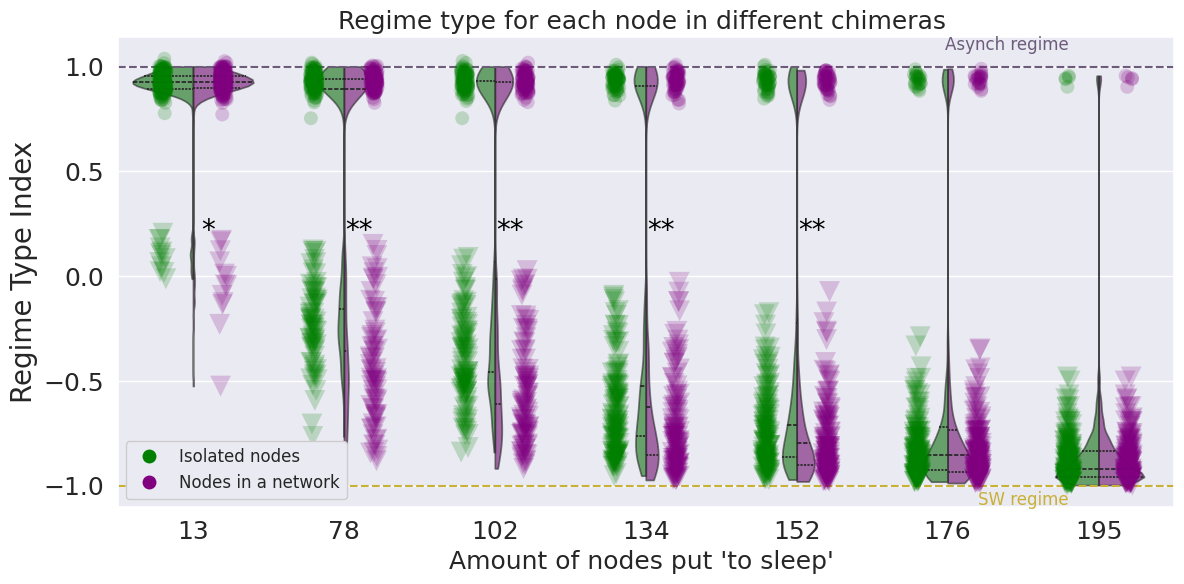

In [ ]:

sns.set(style="darkgrid")

G_VAL = 3.5
LR_HOMO = 10000
LR_HET = 100
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]

LR_HOMO_VEC = np.ones(200)*LR_HOMO
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000

quimeric_delta = np.zeros((len(amount_of_regions),200))
max_freqs_all_het = np.zeros((len(amount_of_regions),100,200))
max_powers_all_het = np.zeros((len(amount_of_regions),100,200))
for NTH_IDX,NTH in enumerate(amount_of_regions):
    print(f"Doing for {NTH} regions")
    SELECTED_REGIONS = most_connected[:NTH]
    LR_HET_VEC = LR_HOMO_VEC.copy()
    LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
    print("Simulating")
    simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
    rates_all_het = np.array(simulations)
    print("Calculating power")
    results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
    for idx, (max_freqs, max_powers, _, _) in enumerate(results):
        max_freqs_all_het[NTH_IDX,idx] = max_freqs
        max_powers_all_het[NTH_IDX,idx] = max_powers
    print("Crafting quimeric delta")    
    quimeric_delta[NTH_IDX] = 2 * (max_freqs_all_het[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000


quimeric_delta_score = np.zeros((len(cherry_pick_scores_idx),200))
max_freqs_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
max_powers_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
for NTH_IDX,NTH in enumerate(cherry_pick_scores_idx):
    print(f"Doing for {NTH} regions")
    SELECTED_REGIONS = score_idxs[NTH]
    LR_HET_VEC = LR_HOMO_VEC.copy()
    LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
    print("Simulating")
    simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
    rates_all_het = np.array(simulations)
    print("Calculating power")
    results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
    for idx, (max_freqs, max_powers, _, _) in enumerate(results):
        max_freqs_all_het_score[NTH_IDX,idx] = max_freqs
        max_powers_all_het_score[NTH_IDX,idx] = max_powers
    print("Crafting quimeric delta")    
    quimeric_delta_score[NTH_IDX] = 2 * (max_freqs_all_het_score[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

os.mkdir(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}")
# Save the results
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy", quimeric_delta)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy", quimeric_delta_score)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy", max_freqs_all_het)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy", max_freqs_all_het_score)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy", max_powers_all_het)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy", max_powers_all_het_score)


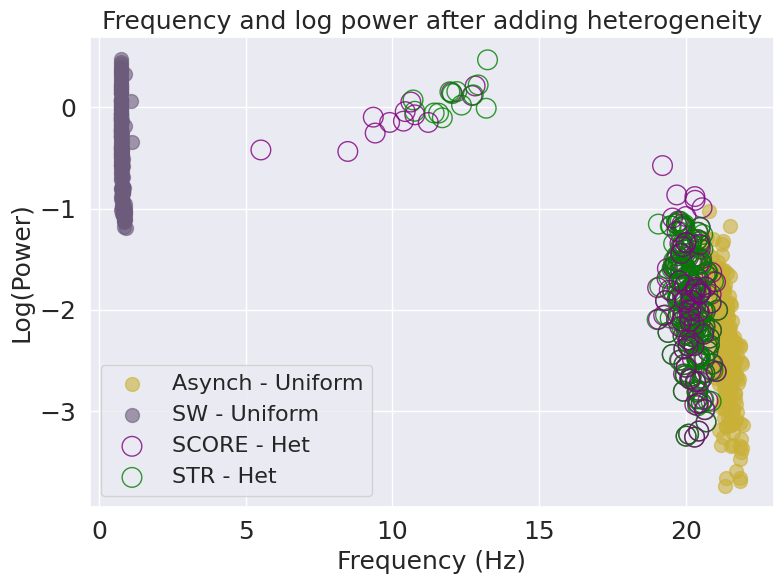

In [ ]:
from turtle import color
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 18
TICKS = 18
LEGEND = 16

# Parameters
figname = 'FIG_6_B'

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots for high and low learning rates
ax.scatter(max_freqs_all_high_lr.mean(axis=0), np.log(max_powers_all_high_lr.mean(axis=0)), label="Asynch - Uniform", alpha=0.6, s=100,color=col_pal_sw_asynch[0])
ax.scatter(max_freqs_all_low_lr.mean(axis=0), np.log(max_powers_all_low_lr.mean(axis=0)), label="SW - Uniform", alpha=0.6, s=100,color=col_pal_sw_asynch[1])
split_idx = max_freqs_all_het.shape[-1] // 2
plt.scatter(max_freqs_all_het_score[0].mean(axis=0)[:split_idx+50], np.log(max_powers_all_het_score[0].mean(axis=0))[:split_idx+50], label="SCORE - Het", alpha=0.8, s=200, color='purple',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het[0].mean(axis=0)[:split_idx], np.log(max_powers_all_het[0].mean(axis=0))[:split_idx], label="STR - Het", alpha=0.8, s=200, color='green',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het[0].mean(axis=0)[split_idx:], np.log(max_powers_all_het[0].mean(axis=0))[split_idx:], label=None, alpha=0.8, s=200, color='green',facecolors='none',zorder=2)
plt.scatter(max_freqs_all_het_score[0].mean(axis=0)[split_idx+50:], np.log(max_powers_all_het_score[0].mean(axis=0))[split_idx+50:], label=None, alpha=0.8, s=200, color='purple',facecolors='none',zorder=2)

# Labels, title, and legend
ax.set_xlabel("Frequency (Hz)", fontsize=LABEL)
ax.set_ylabel("Log(Power)", fontsize=LABEL)
ax.set_title("Frequency and log power after adding heterogeneity", fontsize=TITLE)
ax.tick_params(axis='both', labelsize=TICKS)
ax.legend(fontsize=LEGEND)

# Layout and save
plt.tight_layout()
fig.savefig(os.path.join(figfold, figname + '.png'), dpi=300)
fig.savefig(figfold + figname + '.svg', dpi=300)
plt.show()


Loading quimeric deltas


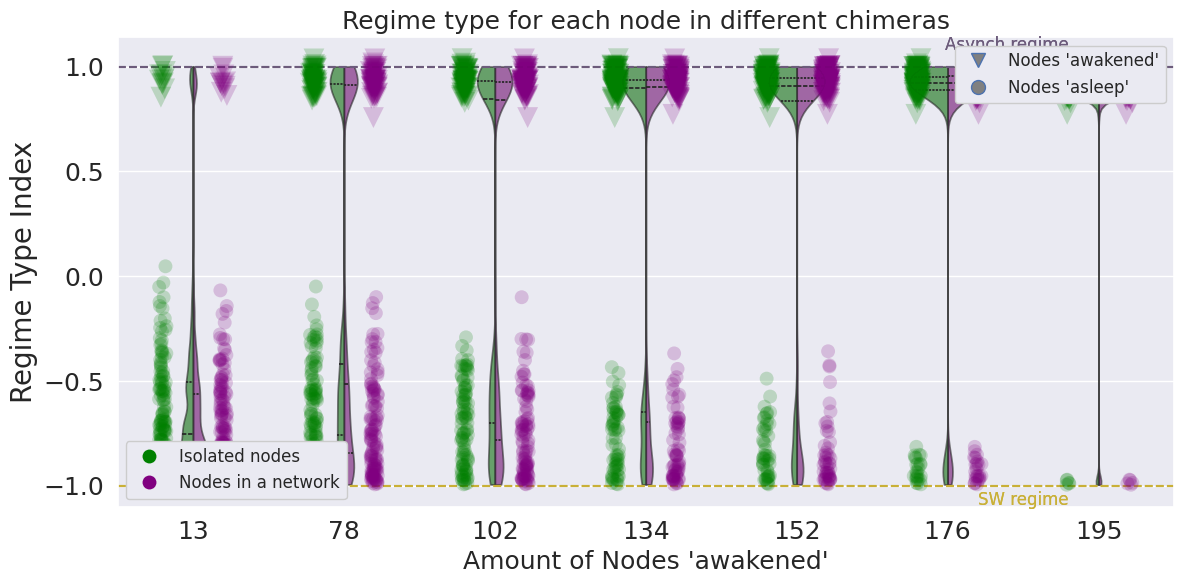

In [ ]:

G_VAL = 3.5
LR_HOMO = 100
LR_HET = 10000
score_lengths = [len(x) for x in score_idxs]
cherry_pick_scores_idx = [-1,-3,-5,-10,-15,-20,-30]
amount_of_regions = [score_lengths[x] for x in cherry_pick_scores_idx ]

LR_HOMO_VEC = np.ones(200)*LR_HOMO
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000

quimeric_delta = np.zeros((len(amount_of_regions),200))
max_freqs_all_het = np.zeros((len(amount_of_regions),100,200))
max_powers_all_het = np.zeros((len(amount_of_regions),100,200))
for NTH_IDX,NTH in enumerate(amount_of_regions):
    print(f"Doing for {NTH} regions")
    SELECTED_REGIONS = most_connected[:NTH]
    LR_HET_VEC = LR_HOMO_VEC.copy()
    LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
    print("Simulating")
    simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
    rates_all_het = np.array(simulations)
    print("Calculating power")
    results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
    for idx, (max_freqs, max_powers, _, _) in enumerate(results):
        max_freqs_all_het[NTH_IDX,idx] = max_freqs
        max_powers_all_het[NTH_IDX,idx] = max_powers
    print("Crafting quimeric delta")    
    quimeric_delta[NTH_IDX] = 2 * (max_freqs_all_het[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000


quimeric_delta_score = np.zeros((len(cherry_pick_scores_idx),200))
max_freqs_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
max_powers_all_het_score = np.zeros((len(cherry_pick_scores_idx),100,200))
for NTH_IDX,NTH in enumerate(cherry_pick_scores_idx):
    print(f"Doing for {NTH} regions")
    SELECTED_REGIONS = score_idxs[NTH]
    LR_HET_VEC = LR_HOMO_VEC.copy()
    LR_HET_VEC[SELECTED_REGIONS] = LR_HET    
    print("Simulating")
    simulations = Parallel(n_jobs=32)(delayed(run_simulation_heterogeneous)(idx, LR_HOMO,LR_HET,SELECTED_REGIONS) for idx in range(100))
    rates_all_het = np.array(simulations)
    print("Calculating power")
    results = Parallel(n_jobs=32)(delayed(get_max_freq_and_power)(rates) for rates in rates_all_het)
    for idx, (max_freqs, max_powers, _, _) in enumerate(results):
        max_freqs_all_het_score[NTH_IDX,idx] = max_freqs
        max_powers_all_het_score[NTH_IDX,idx] = max_powers
    print("Crafting quimeric delta")    
    quimeric_delta_score[NTH_IDX] = 2 * (max_freqs_all_het_score[NTH_IDX].mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) / (max_freqs_all_high_lr.mean(axis=0) - max_freqs_all_low_lr.mean(axis=0)) - 1

os.mkdir(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}")
# Save the results
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta.npy", quimeric_delta)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/quimeric_delta_score.npy", quimeric_delta_score)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het.npy", max_freqs_all_het)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_freqs_all_het_score.npy", max_freqs_all_het_score)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het.npy", max_powers_all_het)
np.save(f"{data_folder}/Quimeric_LR{LR_HOMO}_to_{LR_HET}/max_powers_all_het_score.npy", max_powers_all_het_score)
